In [645]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import geopandas
import geoplot
from shapely.geometry import Polygon, Point
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import geoplot.crs as gcrs
import matplotlib as mpl
import matplotlib.colors as colors

pd.set_option('mode.chained_assignment', None)

# Definitions
## Paths and variables

In [646]:
path = 'C:/Users/Zaca/Documents/Datasets/nyc/'

## Plotting functions

In [647]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100, reverse=False):
   
    if reverse:
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(maxval, minval, n))) 
        
        arr = np.linspace(0, 50, 100).reshape((10, 10))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
        ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
        plt.show()
                
        return new_cmap
   
    else:
        new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
        
        arr = np.linspace(0, 50, 100).reshape((10, 10))
        fig, ax = plt.subplots(ncols=2)
        ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
        ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
        plt.show()
        
        return new_cmap
    
def default_plot(ax, spines): 
    
    ax = plt.gca()
    # Remove unnecessary axes and ticks (top and bottom)
    ax.spines["top"].set_visible(False)   
    ax.spines["right"].set_visible(False)
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    
    # Set the ticks facing OUTWARD
    ax.get_yaxis().set_tick_params(direction='out')
    ax.get_xaxis().set_tick_params(direction='out')
    
    # Remove grid
    #ax.grid('off')
    
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
        
    if 'right' in spines:
        ax.yaxis.set_ticks_position('right')

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')

    return ax
    
def get_colors(cmap, n):
    cmap = mpl.cm.get_cmap(cmap)
    rgba = [cmap(x) for x in np.linspace(0.01, 0.99, n)]
    sns.palplot(sns.color_palette(rgba));    
    return rgba

def get_single_color(cmap, n):
    cmap = mpl.cm.get_cmap(cmap)
    rgba = cmap(n)
    return rgba

def precinct_selected(precinct, basemap):    
    basemap['selected'] = np.where(basemap.precinct == precinct, 1, 0)   
    ax = geoplot.choropleth(basemap, hue='selected', figsize=(8, 8), lw= 1, edgecolor='k', alpha=1, cmap=new_cmap, projection=gcrs.AlbersEqualArea())
    #geoplot.polyplot(basemap[basemap.precinct == precinct], lw=1, facecolor= get_single_color(new_cmap, .99), edgecolor='k', alpha=1)

def view_clusters(basemap, labeled_data):
    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)  
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color=cluster_colors[i], alpha=.75, s=100)
        
def temporal_distribution(labeled_data):   
    fig, ax = plt.subplots(figsize=(6,4))
    ax = default_plot(ax, ['left', 'bottom'])
    plt.xlabel('Time of Day')
    plt.ylabel('Density')
    plt.xlim(0, 24)
    
    min_time = []
    max_time = []
    
    for i in range(len(labeled_data.labels.unique())):
        sns.kdeplot(labeled_data[labeled_data.labels == i].time, bw=1.5, color=cluster_colors[i], label=str(i+1), lw=3)
        min_time += [np.quantile(labeled_data[labeled_data.labels == i].time, .5) - 4]
        max_time += [np.quantile(labeled_data[labeled_data.labels == i].time, .75) + 4]
    
    return list(zip(min_time, max_time))

## Algorithm functions

In [721]:
def make_contour(longitude, latitude, precinct_polygon, colors, levels):
    
    x = longitude
    y = latitude
    
    # check bounds
    xmin = precinct_polygon.bounds['minx'].values - 0.005
    xmax = precinct_polygon.bounds['maxx'].values + 0.005
    ymin = precinct_polygon.bounds['miny'].values - 0.005
    ymax = precinct_polygon.bounds['maxy'].values + 0.005
    
    # Create meshgrid
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    cset = plt.contour(xx, yy, f, colors=colors, levels=levels, linewidths=1.5)
    
    return cset


def get_level(contour, n):
    
    # the n gives you the level
    # just remember that its backwards
    # the outermost level is 0
    
    x = []
    y = []
    for j in range(len(contour.allsegs)):
        for ii, seg in enumerate(contour.allsegs[j]):
            x += [seg[:,0]]
            y += [seg[:,1]]
    
    return list(zip(x[n], y[n]))  


def get_view_contours(basemap, labeled_data, precinct, levels):
    
    fig, ax = plt.subplots()
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    contours = []
    for i in range(len(labeled_data.labels.unique())):
        ctr = make_contour(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], basemap[basemap.precinct == labeled_data.precinct.values[0]]['geometry'], colors=cluster_colors[i], levels=levels)
        contours += [ctr]

    levels = [get_level(x, 0) for x in contours]

    ax = geoplot.polyplot(basemap[basemap.precinct == labeled_data.precinct.values[0]], figsize=(8, 8), lw= 2, facecolor= 'None', edgecolor='k', alpha=1)
    for i in range(len(labeled_data.labels.unique())):
        ax.scatter(labeled_data[labeled_data.labels == i]['longitude'], labeled_data[labeled_data.labels == i]['latitude'], color=cluster_colors[i], alpha=.5, s=100)
        ax.plot([x[0] for x in levels[i]], [x[1] for x in levels[i]], color=cluster_colors[i], lw=3)
        
    return levels

def make_clusters(data, n):
    
    data = data[['latitude', 'longitude', 'time']]
    stdscaler = StandardScaler()
    features = stdscaler.fit_transform(data)
    #cluster = KMeans(n)
    cluster = AgglomerativeClustering(n)
    model = cluster.fit(features)
    
    # re-label so that cluster 0 is always the largest and so on.
    data['labels'] = model.labels_
    re_labeling = data.labels.value_counts().reset_index()['index']
    data['new_labels'] = data['labels'].replace(list(re_labeling.values), list(re_labeling.index))
    
    return data.new_labels.values

# Choosing colors

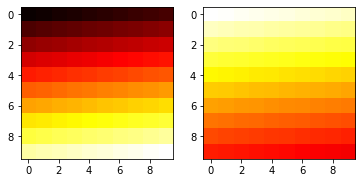

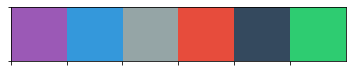

In [621]:
cmap = plt.get_cmap('hot')
new_cmap = truncate_colormap(cmap, 0.35, 1, reverse=True)

#cluster_colors = get_colors(cmap='cool_r', n=4)
#cluster_colors = ["#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
cluster_colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(cluster_colors));

# Preparing base maps

In [622]:
# open shapefile
pcints = geopandas.read_file(path + 'nypd_precincts.shp').to_crs(epsg=4326)

# clean a variable dtypes
pcints['pct'] = pcints['pct'].astype('int32')

# create a new, clean GeoDataFrame
clean_map = geopandas.GeoDataFrame()
clean_map['precinct'] = pcints['pct'].unique()
clean_map['geometry'] = [Polygon(max(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union, key=lambda a: a.area).exterior) if pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.geom_type == 'MultiPolygon' else Polygon(pcints.loc[pcints['pct'] == pct, 'geometry'].unary_union.exterior) for pct in clean_map.precinct]

# Read pre-processed data

In [378]:
crime = pd.read_csv(path + 'nypd_historic_07-18.csv', index_col=0)
# transform to datetime
crime['date'] = pd.to_datetime(crime['date'])

C:\Users\Zaca\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Select crime type

In [702]:
#desc = 'ROBBERY'
#loc = 'STREET'
desc = 'BURGLARY'
loc = 'RESID'
ds = crime[(crime.description == desc) & (crime.premises.str.contains(loc))]

# look at number of crime per precinct for exploration
highest_ = ds.groupby('precinct').agg(count=('date', 'count')).sort_values(by='count', ascending=False)
highest_[:50]

count
precinct       
75         4401
83         4158
105        4042
109        3595
52         3564
67         3398
113        3368
114        3269
47         3264
43         3059
104        3015
115        2815
70         2785
79         2735
61         2730
110        2637
90         2599
102        2522
81         2513
49         2512
77         2484
62         2478
66         2468
44         2448
106        2394
107        2378
120        2334
73         2293
103        2252
111        2192
46         2085
48         2072
71         2008
34         1963
63         1937
68         1906
69         1808
108        1750
45         1668
122        1612
72         1597
19         1572
94         1501
50         1485
40         1438
101        1419
42         1386
60         1378
9          1312
78         1212

# Select time and space

In [671]:
training_period = ['2017-01-01', '2017-12-31']
testing_period=['2018-01-01', '2018-12-31']

n_clusters = 6
n_levels = 3

precinct = 73

subselection = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]

# Define and select clustering algorithm

In [672]:
# run clustering algorithm and get labels
subselection['labels'] = make_clusters(subselection, n_clusters)

# Showing selected area

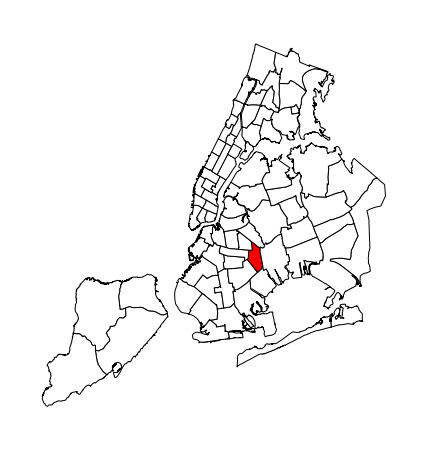

In [673]:
precinct_selected(precinct, clean_map)

# View clusters

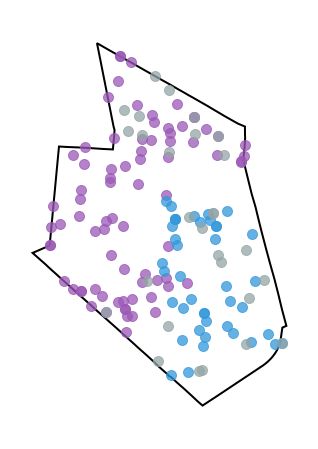

In [674]:
view_clusters(clean_map, subselection)

# Temporal distribution of clusters

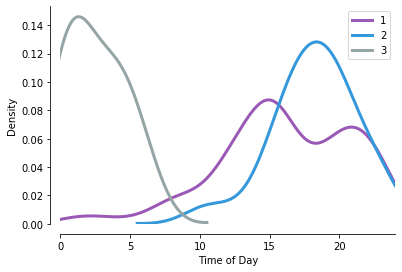

In [675]:
time_windows = temporal_distribution(subselection)

# Estimate kernel density and grab contours

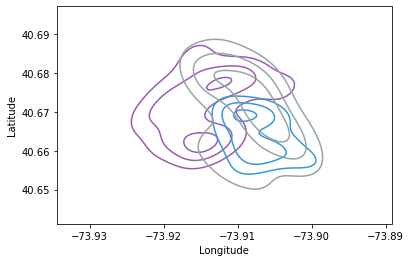

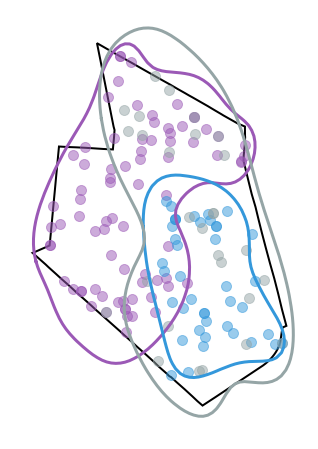

In [677]:
contours = get_view_contours(clean_map, subselection, precinct, levels=n_levels)

# Define clusters

In [678]:
zones = [Polygon(x) for x in contours]
start_time = [x[0] for x in time_windows]
end_time = [x[1] for x in time_windows]

# Select test data

In [679]:
testing_period = ['2017-04-01', '2017-07-01']
test_selection = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)

In [680]:
test_points = [Point(x, y) for x, y in list(zip(test_selection.longitude, test_selection.latitude))]
test_times = list(test_selection.time.values)

# Running tests

In [681]:
landed = 0
for cluster in range(n_clusters):
    for test in range(len(test_points)):
        if (test_points[test].within(zones[cluster])) and (start_time[cluster] <= test_times[test] <= end_time[cluster]):
            landed += 1

In [682]:
print('Burglaries spatio-temporally located:', landed/len(test_points)*100)

Burglaries spatio-temporally located: 82.85714285714286


In [419]:
# Main function

In [420]:
#training_period = ['2017-01-01', '2017-04-01']
#testing_period = ['2017-04-01', '2017-07-01']
#precinct = 75
#n_clusters = 4

In [587]:
def main(ds, training_period, precinct, n_clusters, testing_period, n_levels=n_levels):
    
    subselection = ds[(ds.date > training_period[0]) & (ds.date < training_period[1]) & (ds.precinct == precinct)]
    subselection['labels'] = make_clusters(subselection, n_clusters)
    precinct_selected(precinct, clean_map)
    view_clusters(clean_map, subselection)
    time_windows = temporal_distribution(subselection)
    contours = get_view_contours(clean_map, subselection, precinct=precinct, levels=n_levels)
    
    zones = [Polygon(x) for x in contours]
    start_time = [x[0] for x in time_windows]
    end_time = [x[1] for x in time_windows]
    
    test_selection = ds[(ds.date > testing_period[0]) & (ds.date < testing_period[1]) & (ds.precinct == precinct)][['latitude', 'longitude', 'time']].reset_index(drop=True)
    test_points = [Point(x, y) for x, y in list(zip(test_selection.longitude, test_selection.latitude))]
    test_times = list(test_selection.time.values)
    
    landed = 0
    for cluster in range(n_clusters):
        for test in range(len(test_points)):
            if (test_points[test].within(zones[cluster])) and (start_time[cluster] <= test_times[test] <= end_time[cluster]):
                landed += 1
                
    score = landed/len(test_points)
    print('Precinct:', precinct)
    print('Burglaries located:', score*100)
    
    return score

# For every precinct

In [723]:
# get list of precincts
precincts = list(highest_.index[:30])

In [724]:
#precincts.remove(18)
#precincts.remove(13)
#precincts.remove(10)
#precincts.remove(17)
#precincts.remove(1)
#precincts.remove(26)
precincts.remove(44)
precincts

[75,
 83,
 105,
 109,
 52,
 67,
 113,
 114,
 47,
 43,
 104,
 115,
 70,
 79,
 61,
 110,
 90,
 102,
 81,
 49,
 77,
 62,
 66,
 106,
 107,
 120,
 73,
 103,
 111]

Precinct: 75
Burglaries located: 72.6962457337884
Precinct: 83
Burglaries located: 63.10679611650486
Precinct: 105
Burglaries located: 84.34343434343434
Precinct: 109
Burglaries located: 77.67857142857143


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Precinct: 52
Burglaries located: 85.23489932885906


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 67
Burglaries located: 65.51724137931035


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 113
Burglaries located: 87.06896551724138


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 114
Burglaries located: 84.94623655913979


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 47
Burglaries located: 67.3469387755102


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Precinct: 43
Burglaries located: 62.4


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 104
Burglaries located: 75.67567567567568


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 115
Burglaries located: 62.20472440944882


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 70
Burglaries located: 53.84615384615385


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 79
Burglaries located: 81.32530120481928


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 61
Burglaries located: 88.11881188118812


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 110
Burglaries located: 68.42105263157895


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 90
Burglaries located: 50.0


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 102
Burglaries located: 50.0


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 81
Burglaries located: 68.18181818181817


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 49
Burglaries located: 65.26315789473685


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 77
Burglaries located: 72.32142857142857


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 62
Burglaries located: 90.32258064516128


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 66
Burglaries located: 85.18518518518519


C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, 

Precinct: 106
Burglaries located: 57.831325301204814


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 107
Burglaries located: 86.11111111111111


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=self.figsize)
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, se

Precinct: 120
Burglaries located: 40.0


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 73
Burglaries located: 74.56140350877193


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 103
Burglaries located: 67.03296703296702


C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\Zaca\Anaconda3\lib\site-packages\geoplot\geoplot.py:610: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_wa

Precinct: 111
Burglaries located: 68.50393700787401


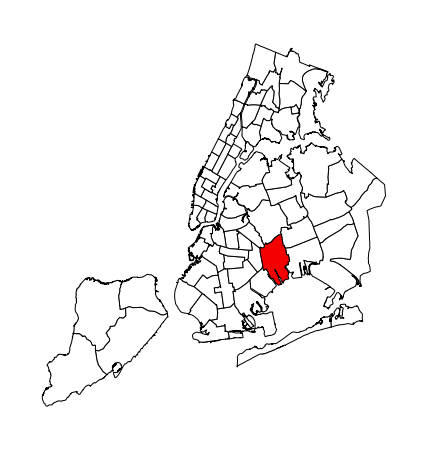

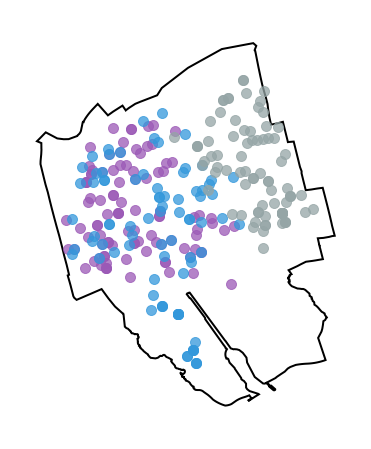

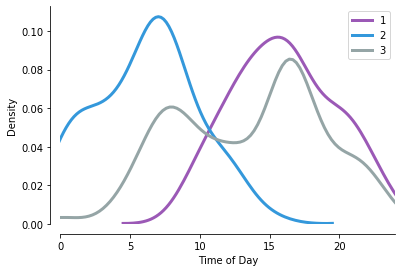

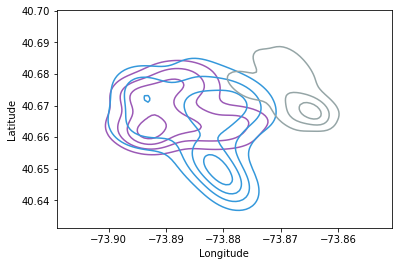

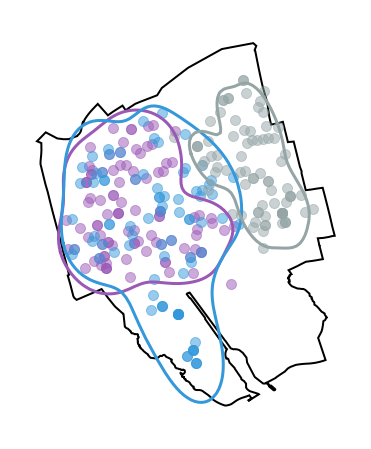

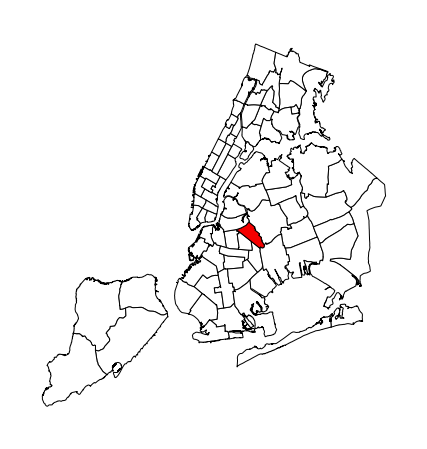

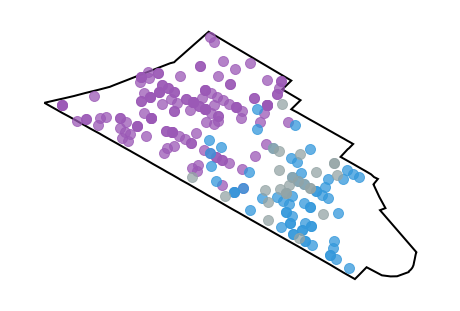

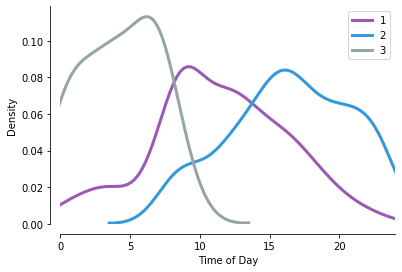

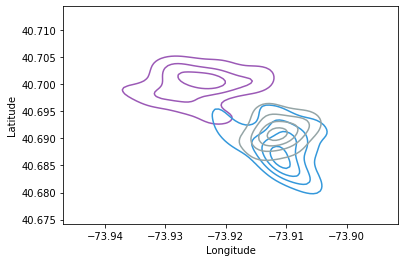

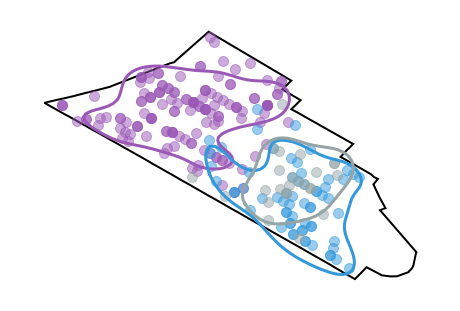

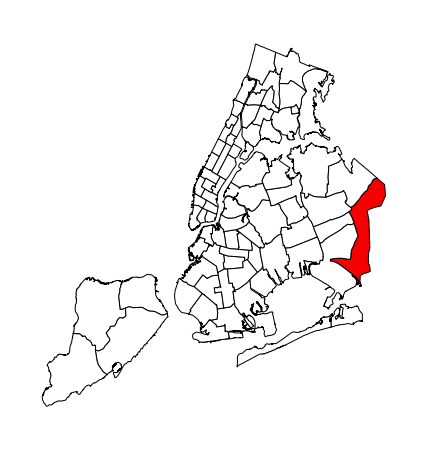

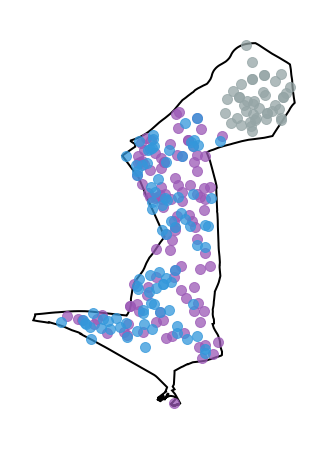

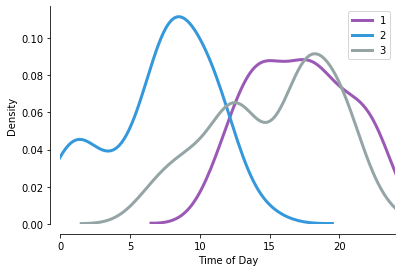

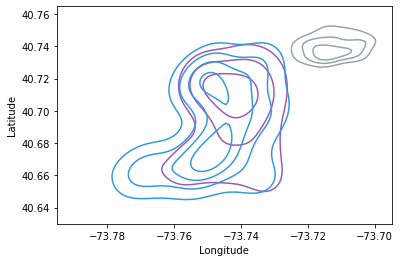

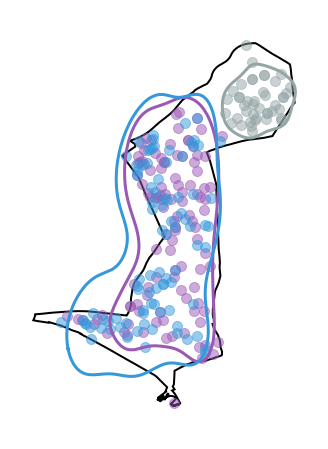

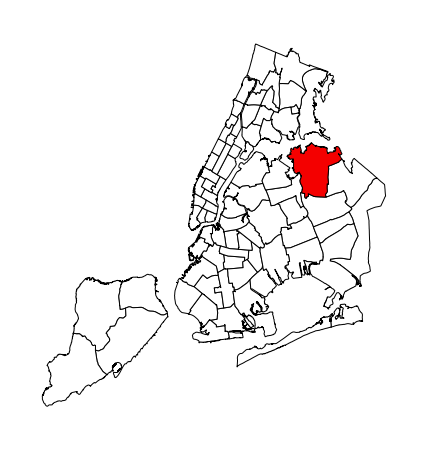

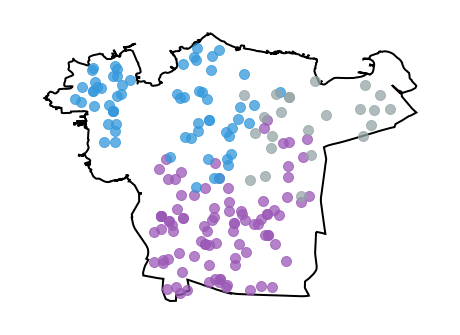

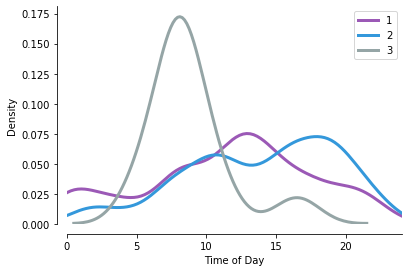

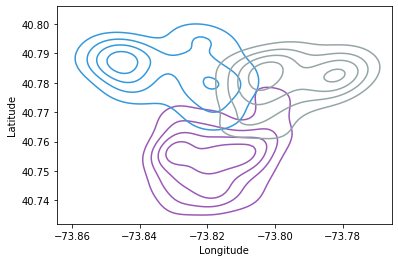

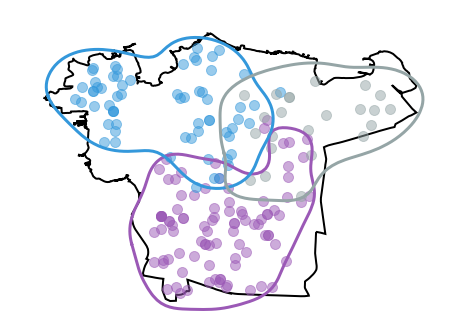

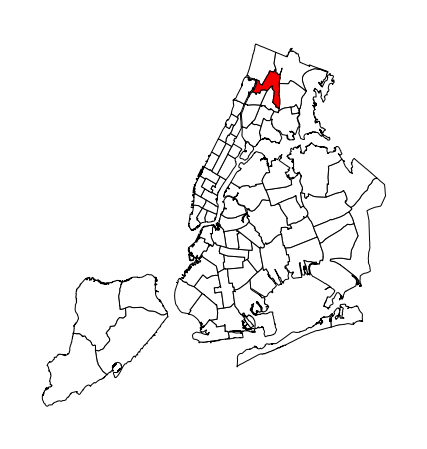

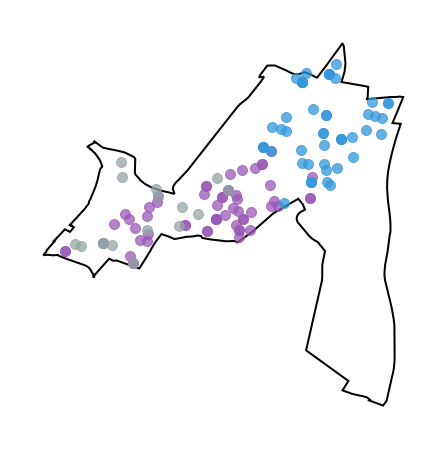

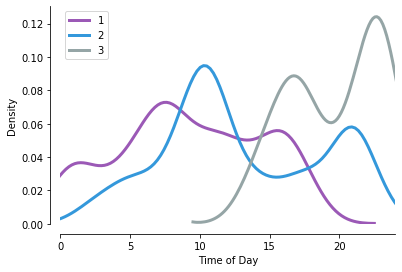

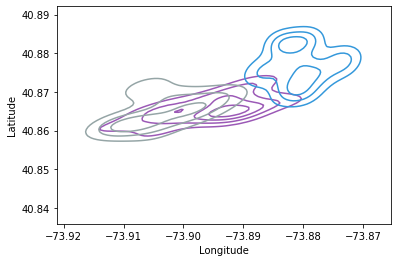

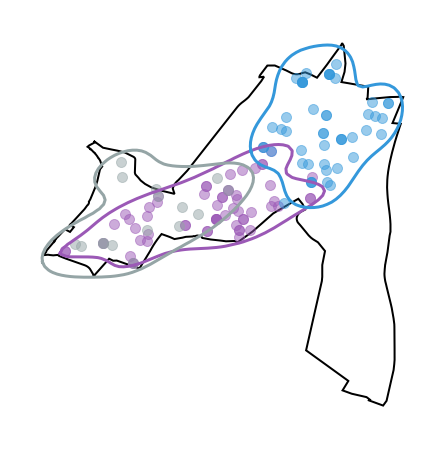

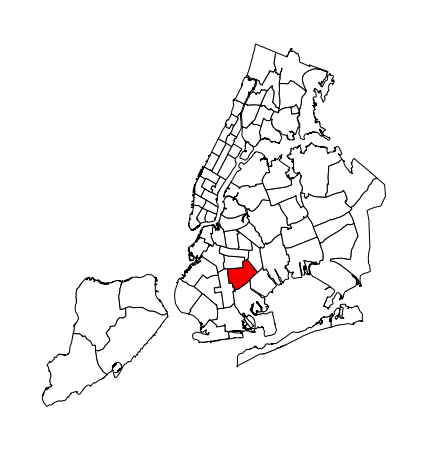

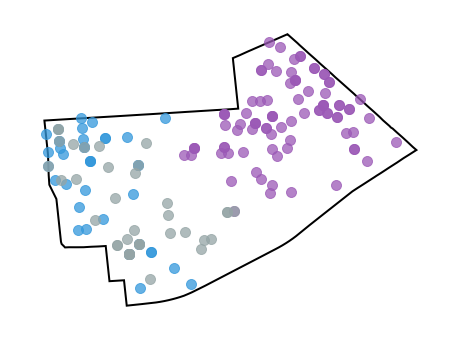

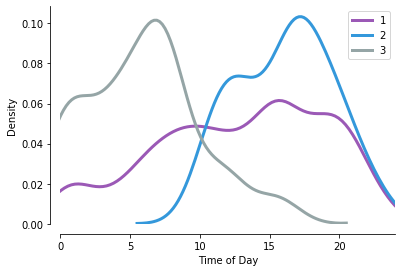

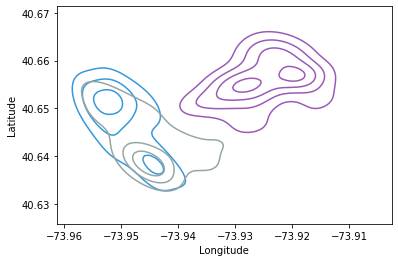

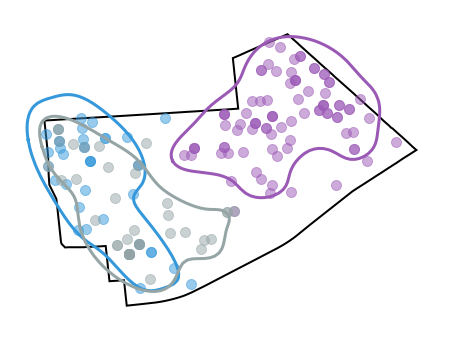

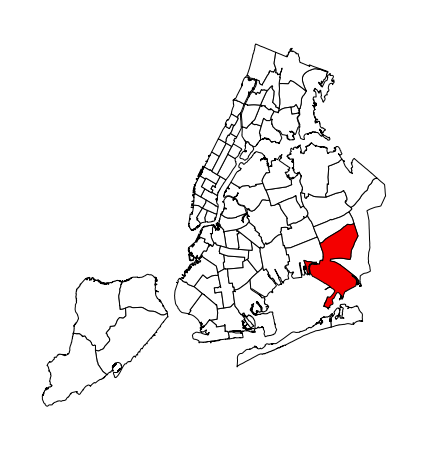

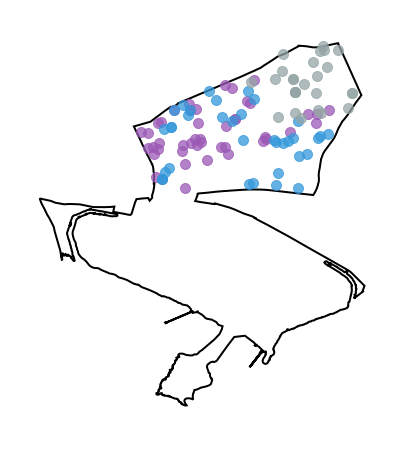

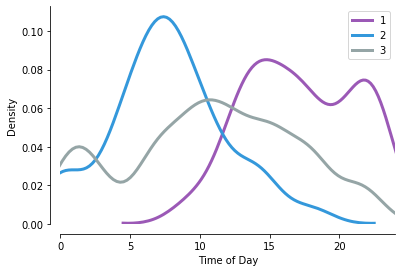

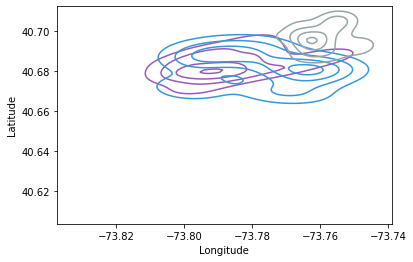

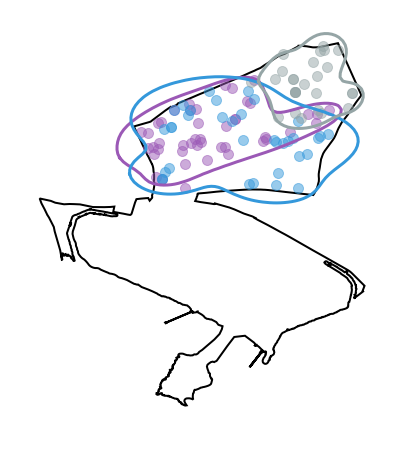

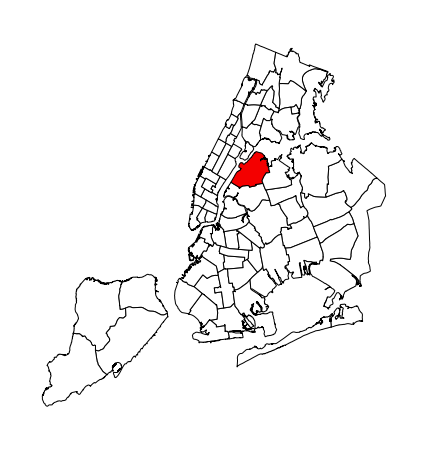

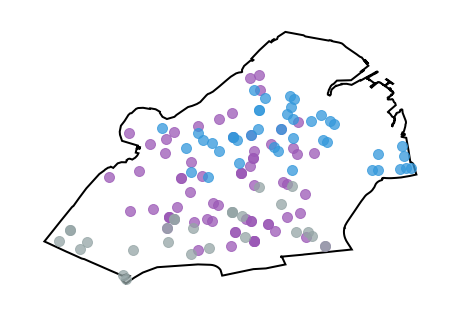

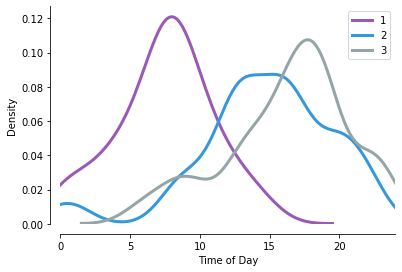

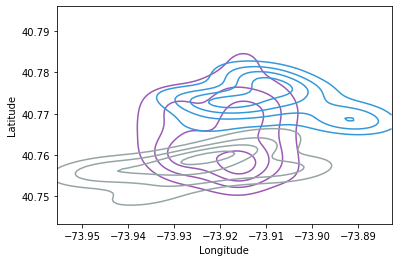

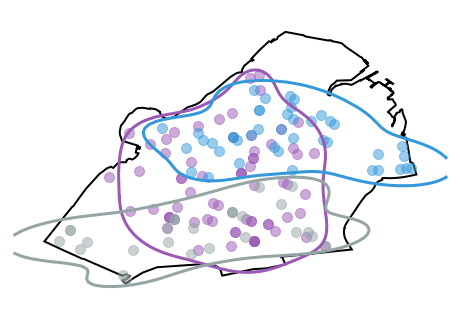

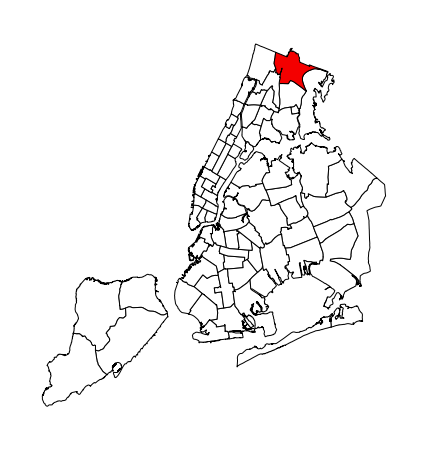

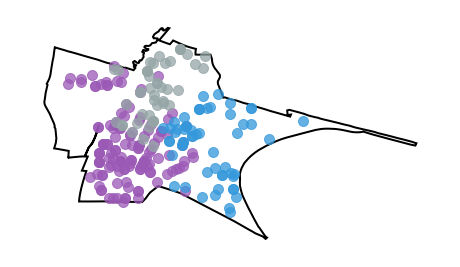

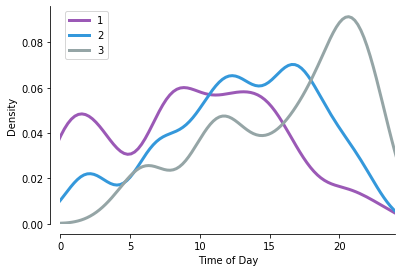

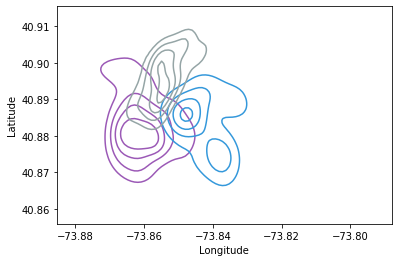

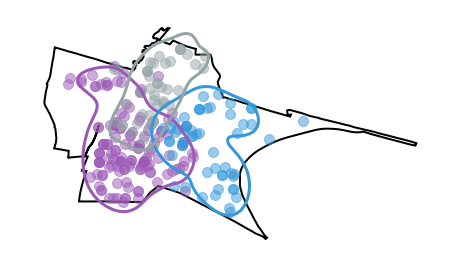

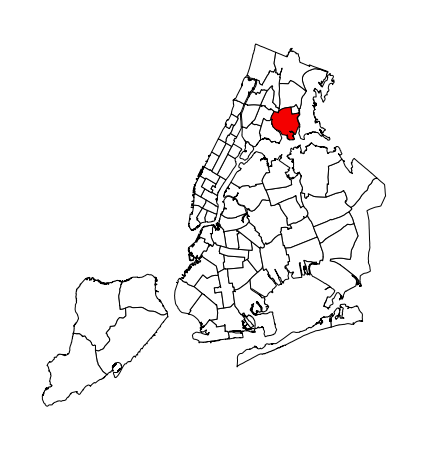

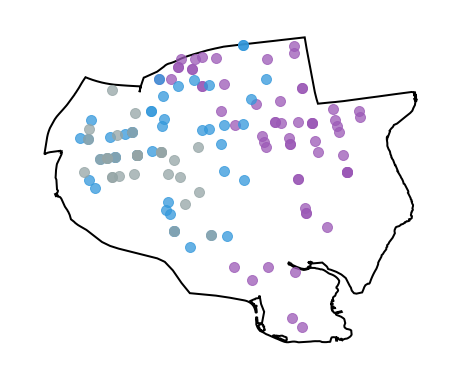

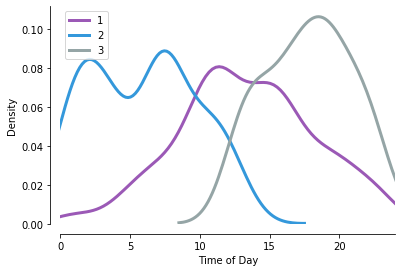

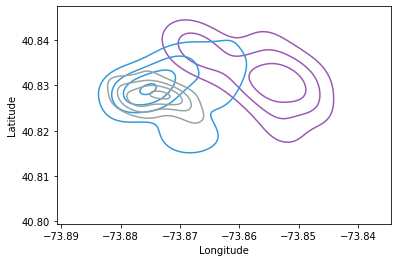

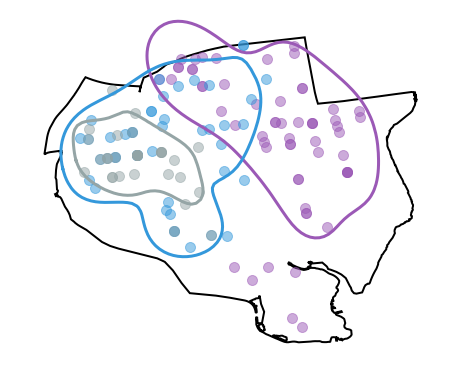

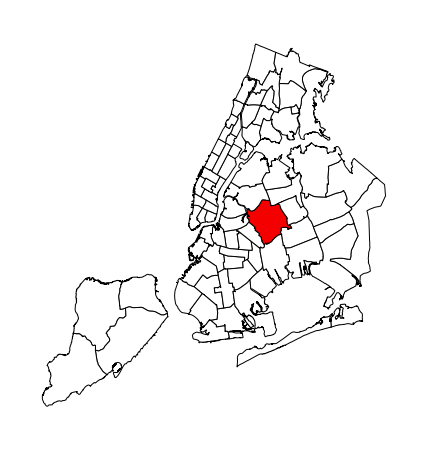

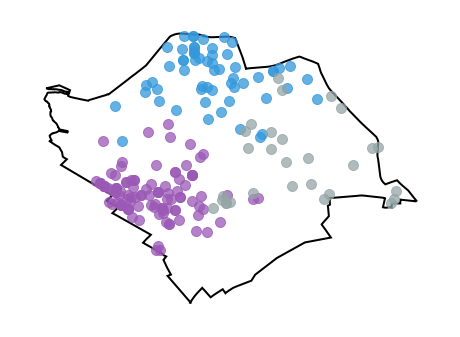

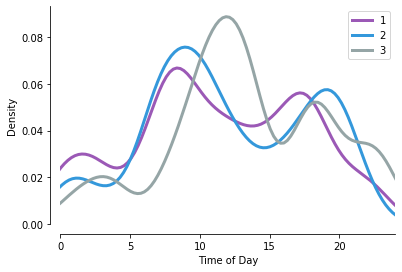

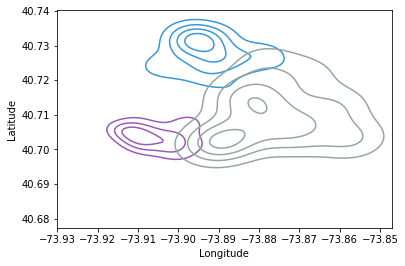

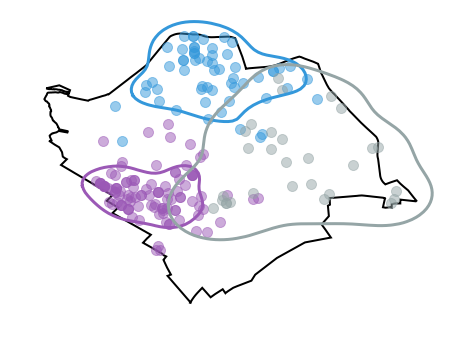

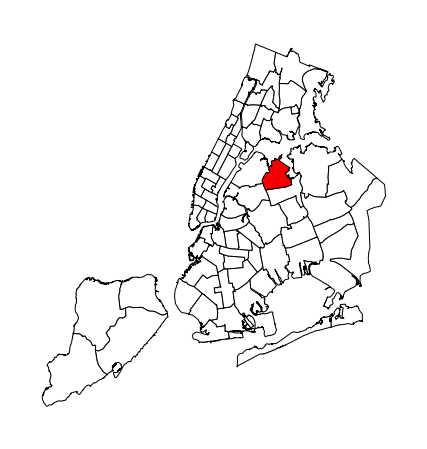

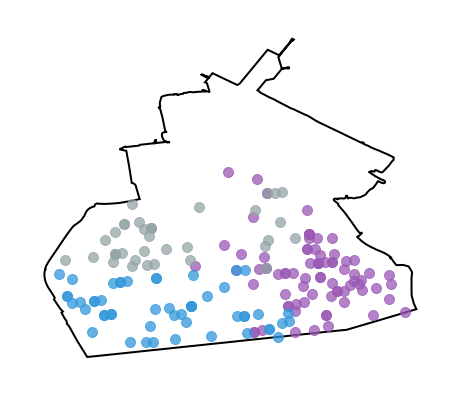

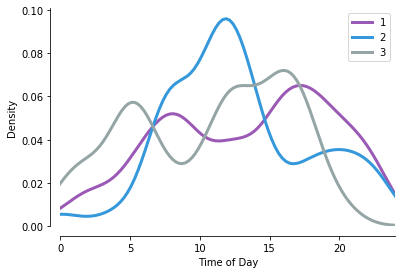

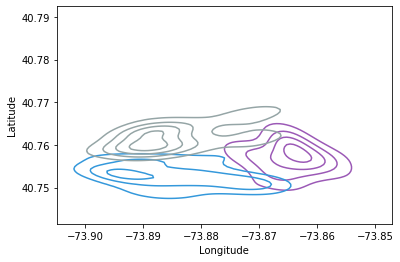

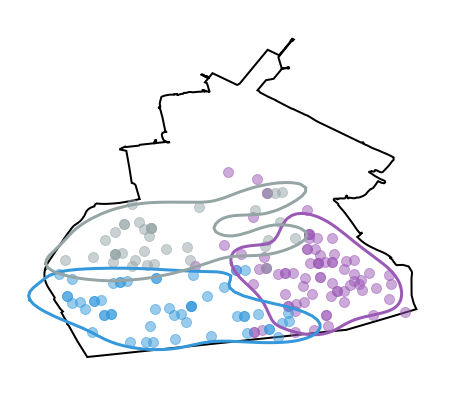

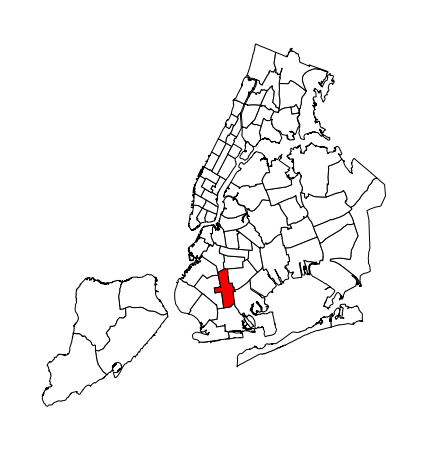

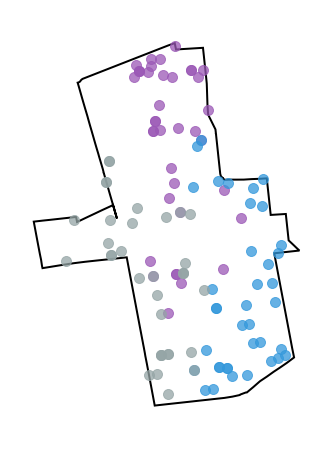

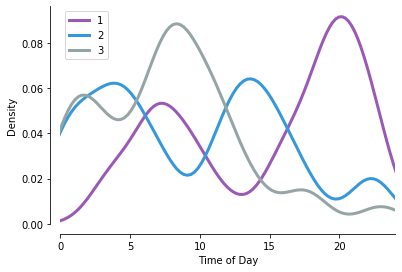

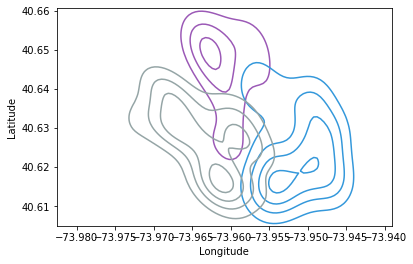

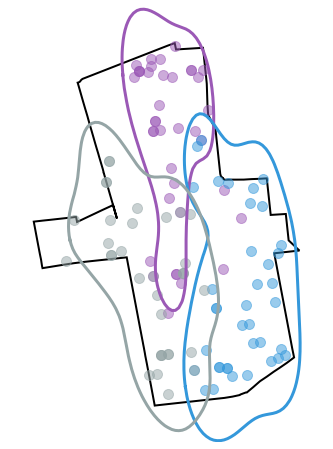

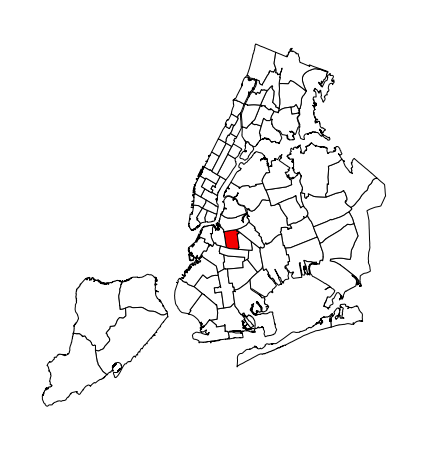

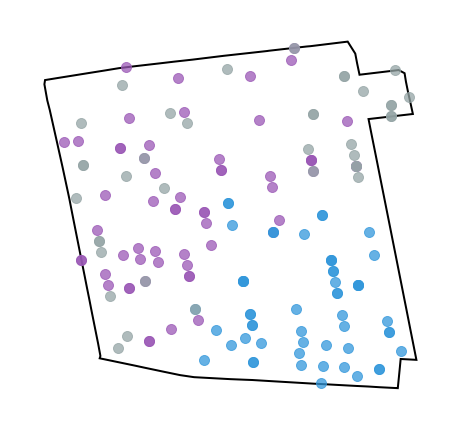

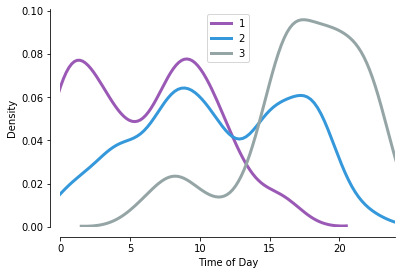

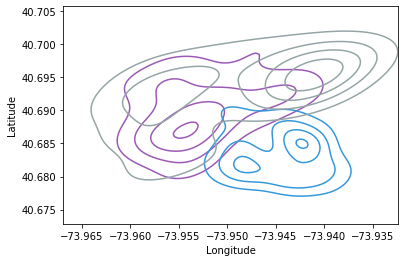

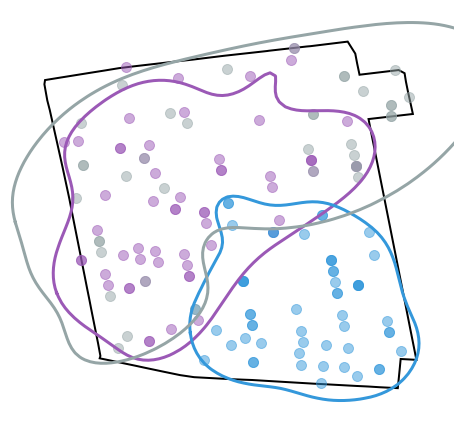

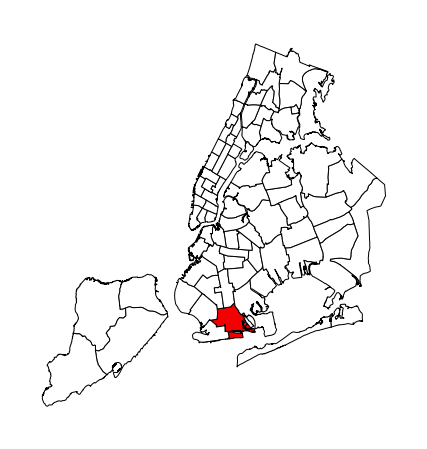

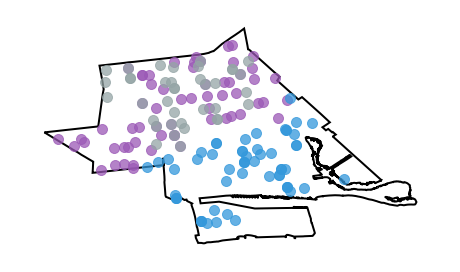

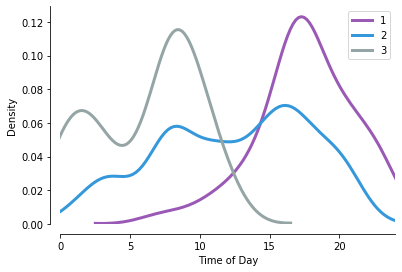

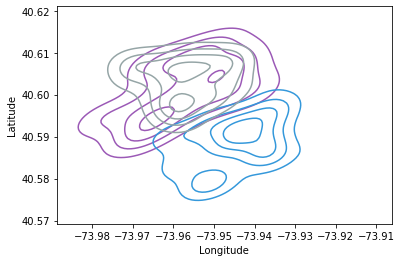

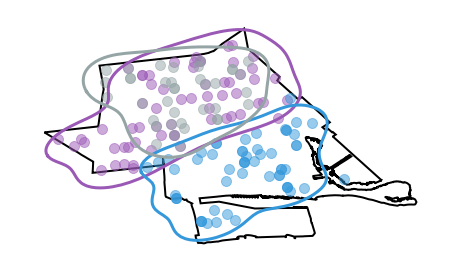

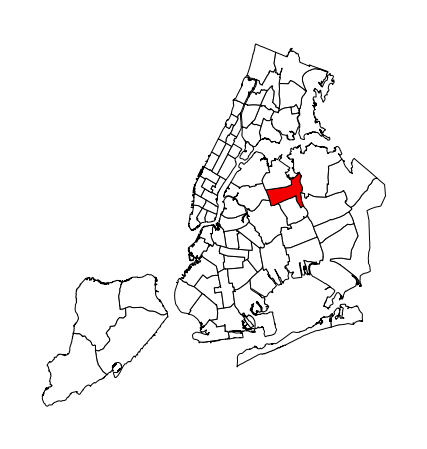

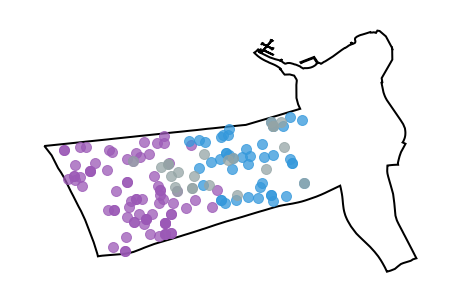

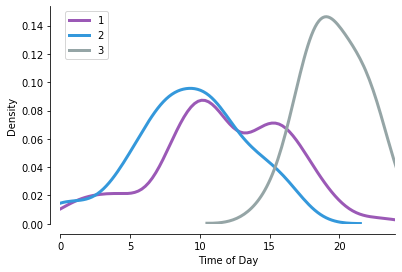

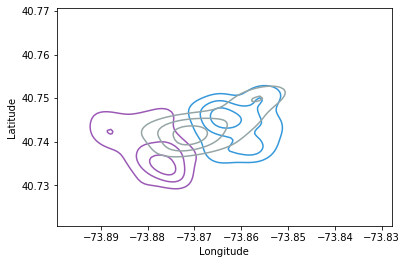

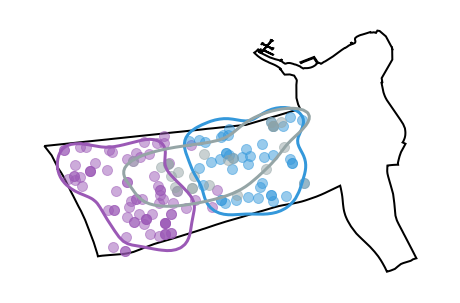

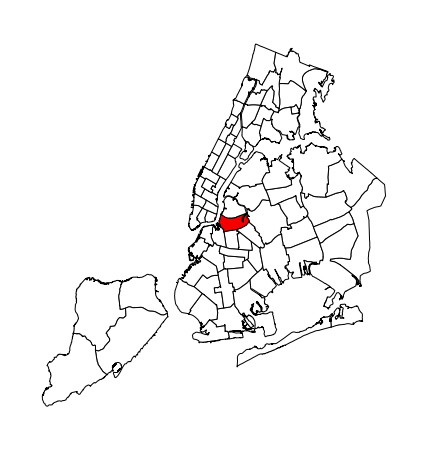

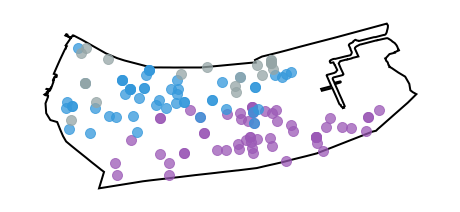

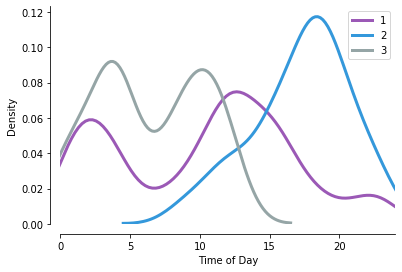

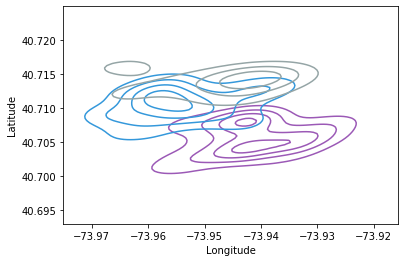

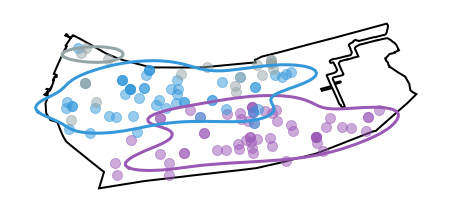

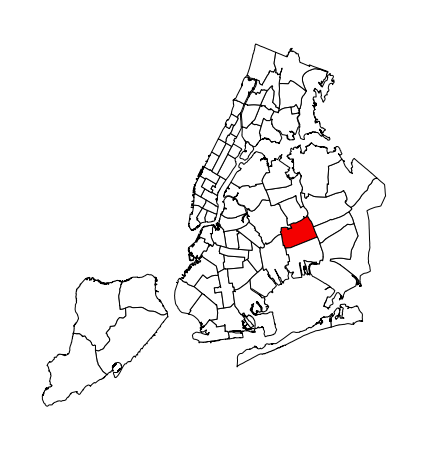

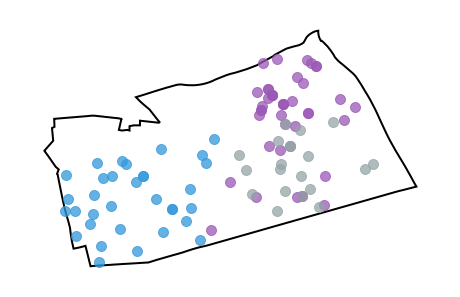

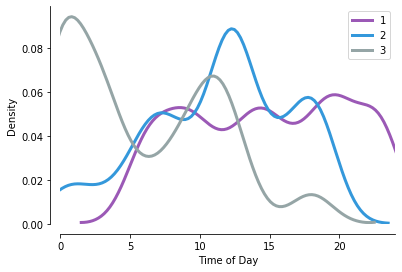

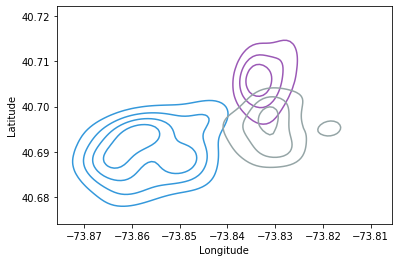

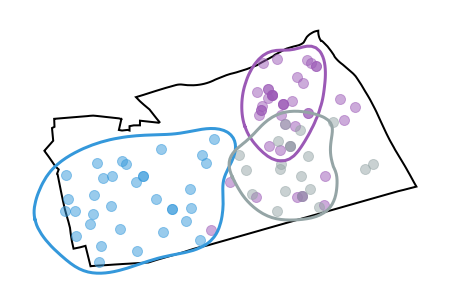

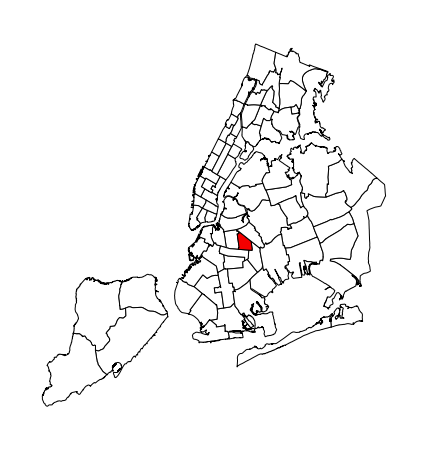

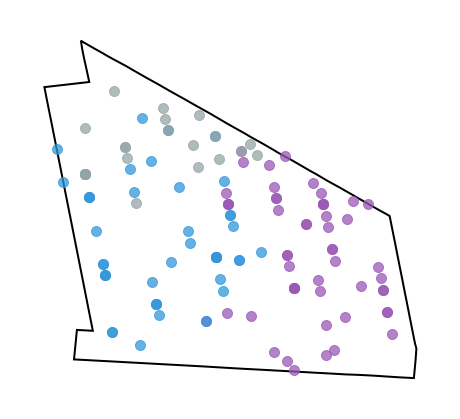

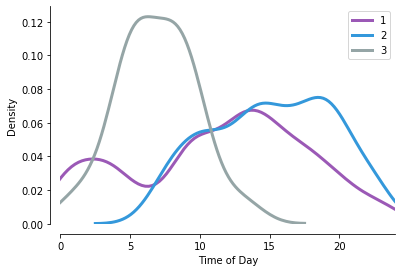

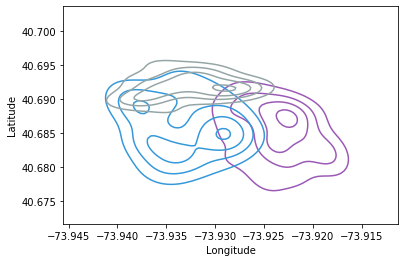

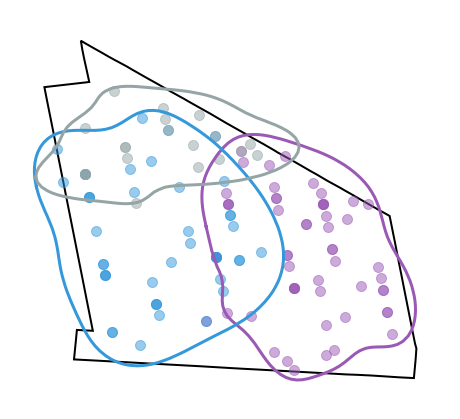

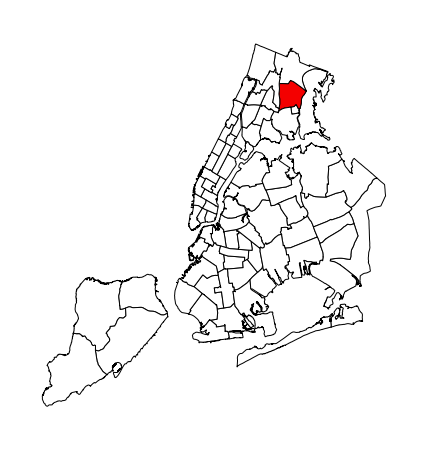

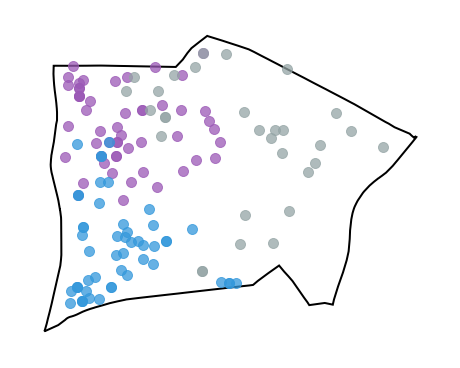

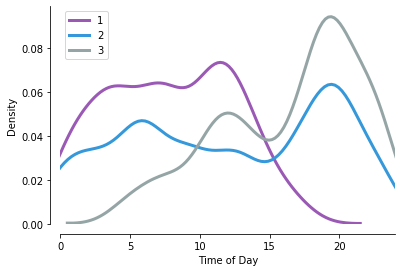

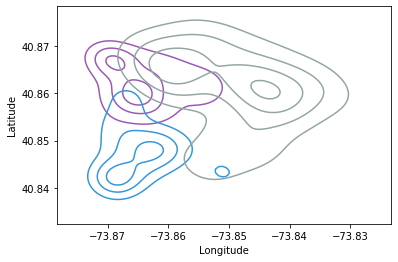

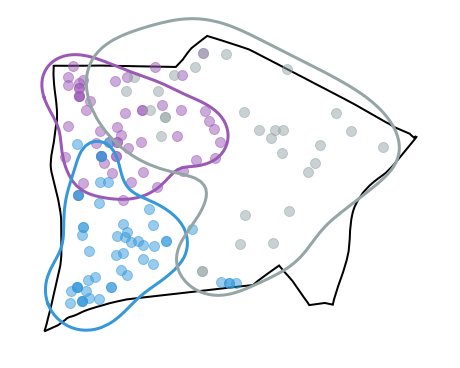

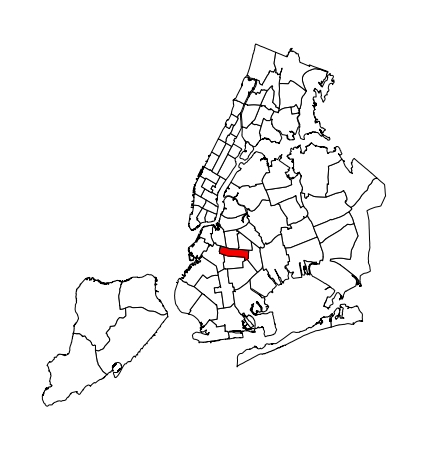

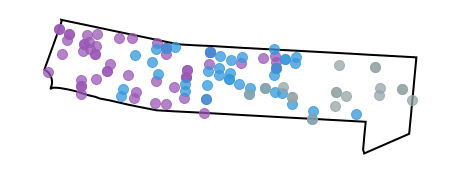

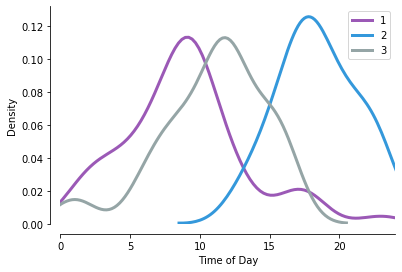

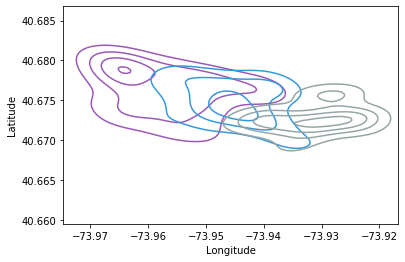

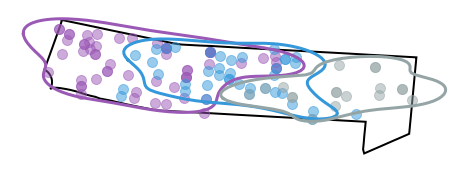

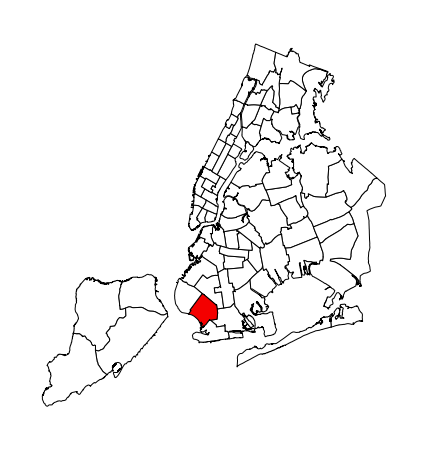

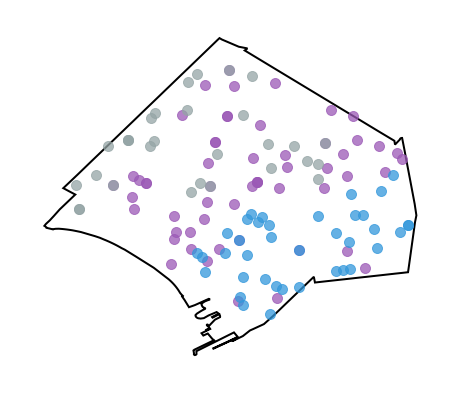

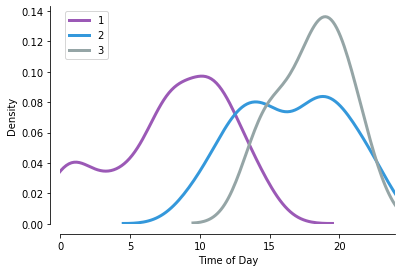

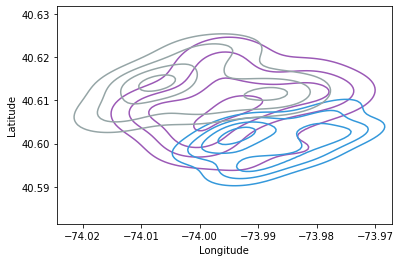

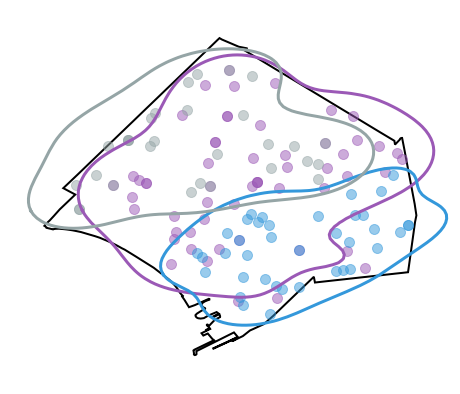

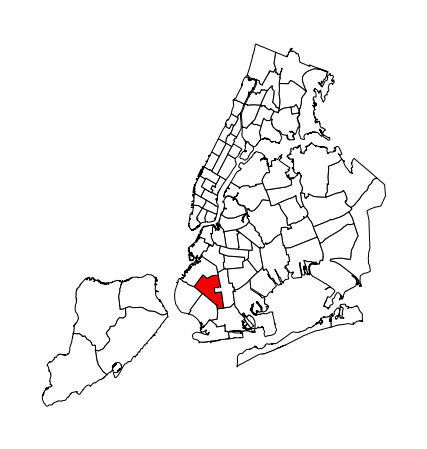

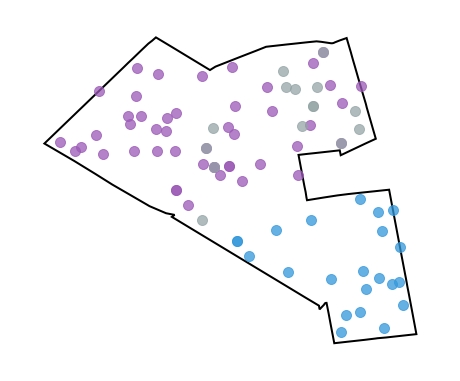

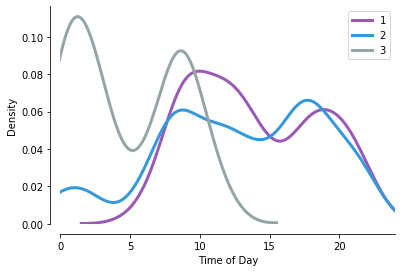

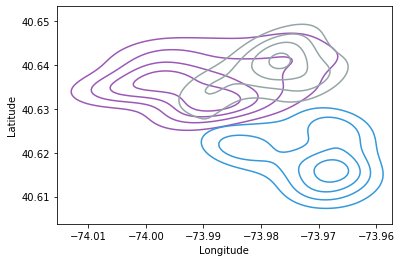

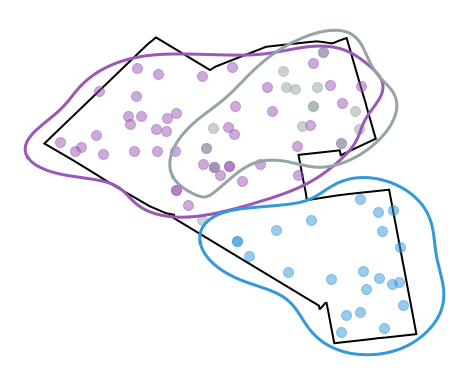

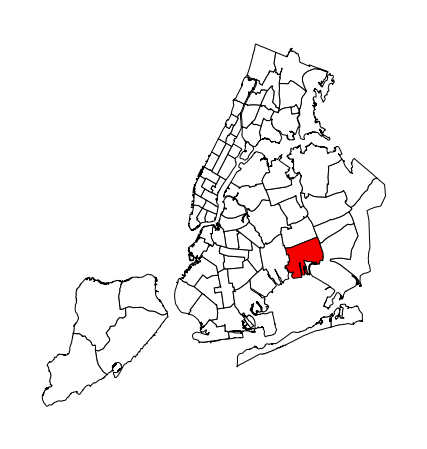

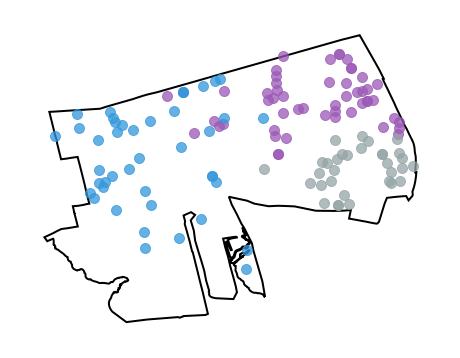

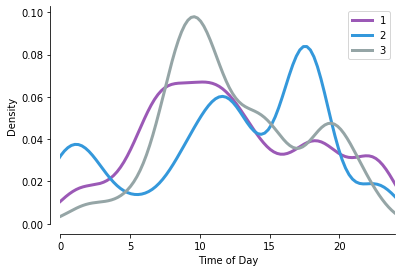

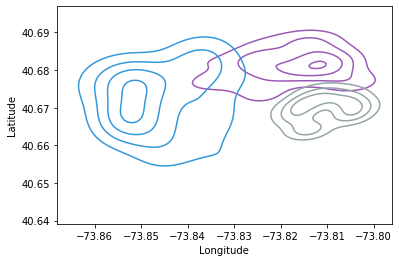

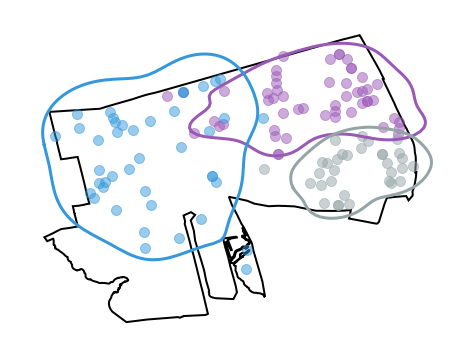

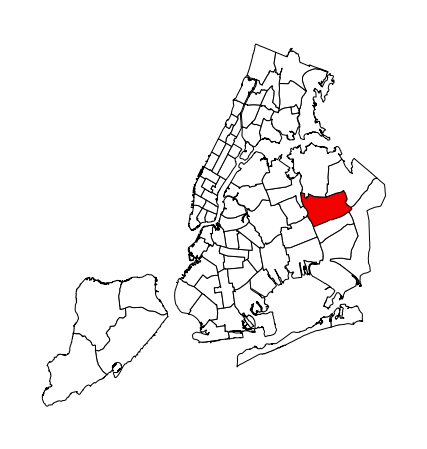

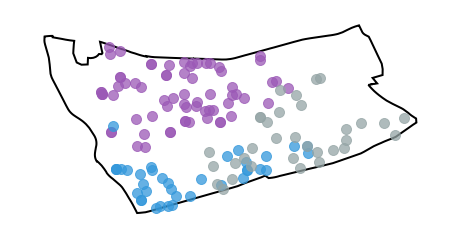

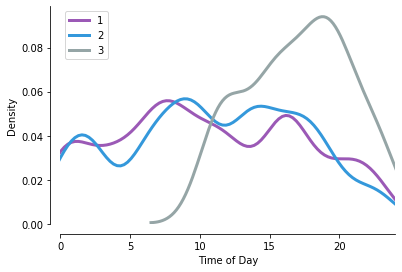

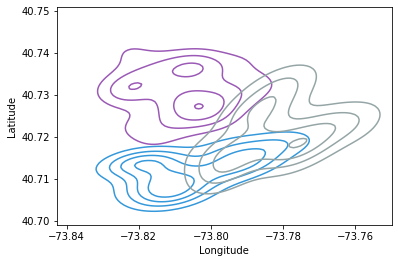

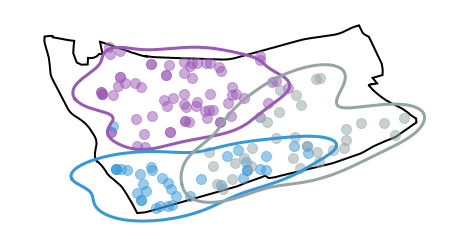

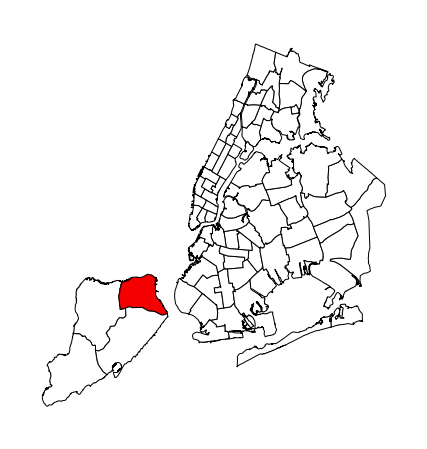

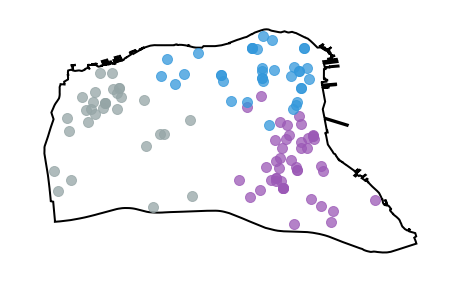

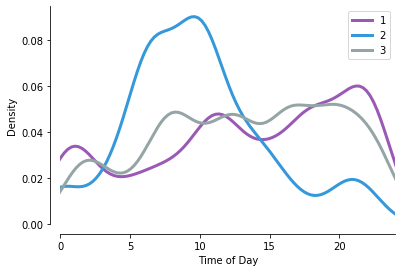

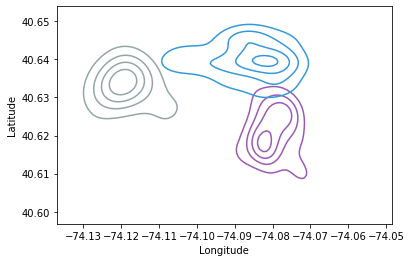

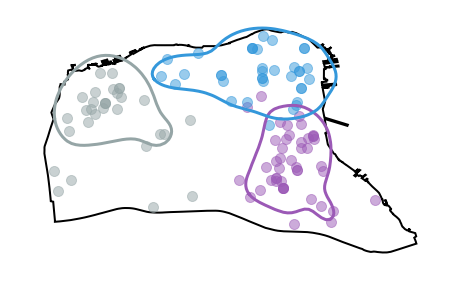

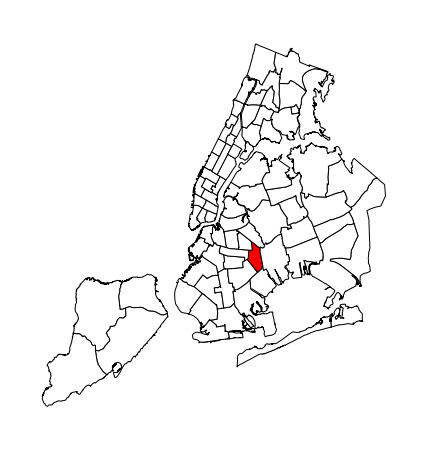

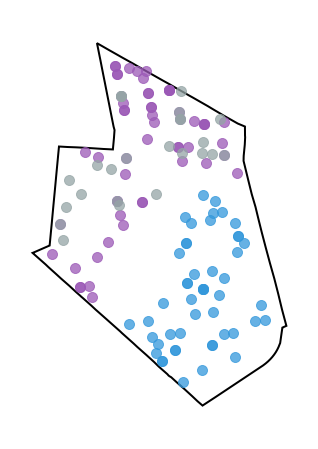

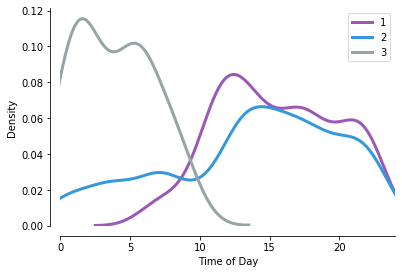

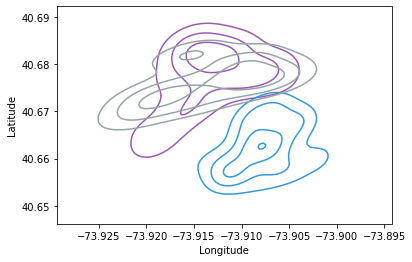

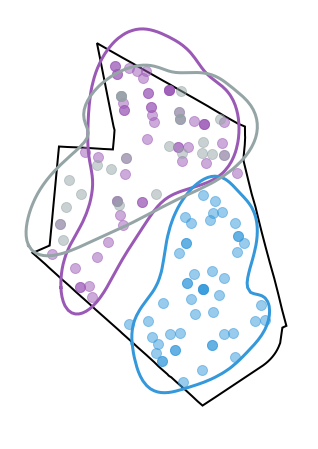

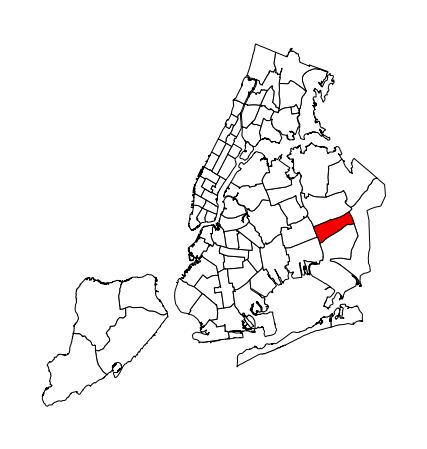

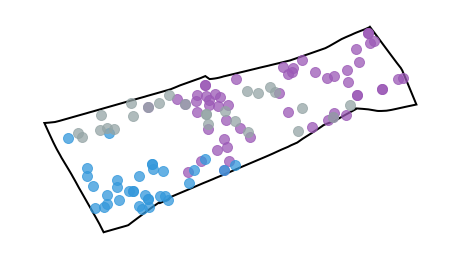

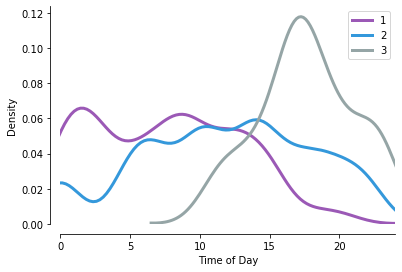

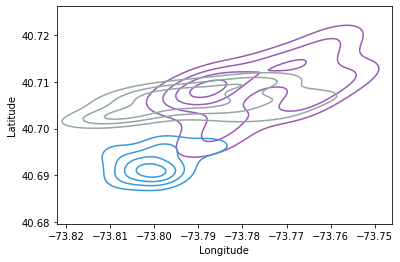

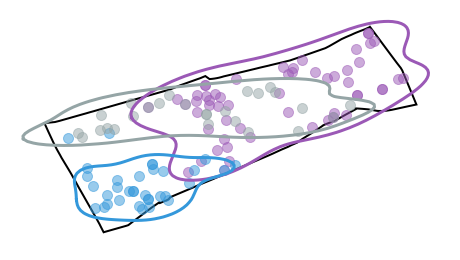

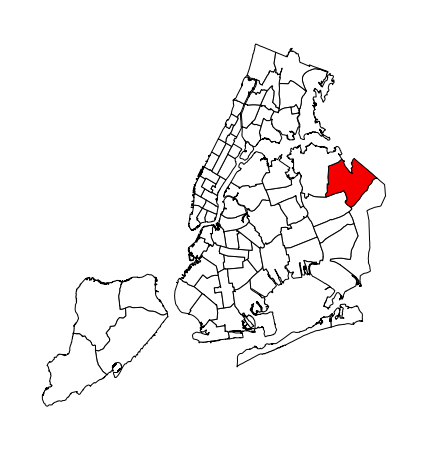

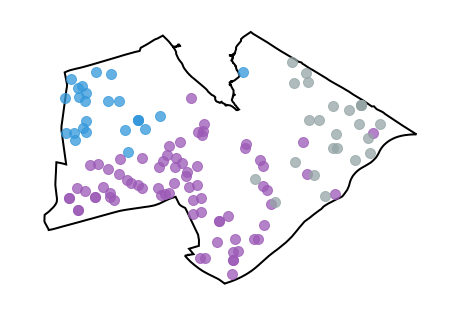

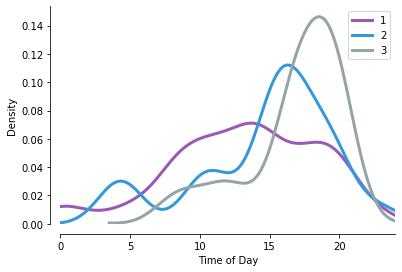

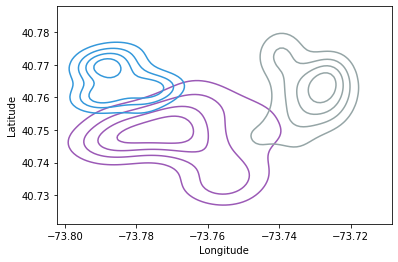

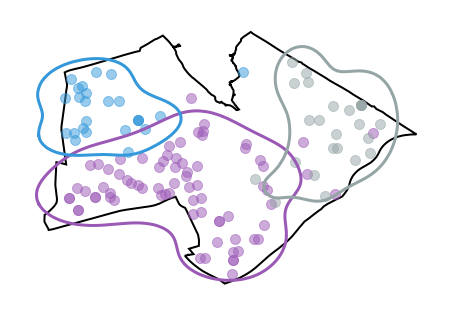

In [725]:
training_period = ['2017-01-01', '2017-12-31']
testing_period=['2018-01-01', '2018-12-31']

n_clusters = 3
n_levels = 4

scores = []
for precinct in precincts:
    scores += [main(ds=ds, training_period=training_period, precinct=precinct, n_clusters=n_clusters, testing_period=testing_period, n_levels=n_levels)]

In [726]:
len(scores)

29

0.6850393700787402


(0, 1)

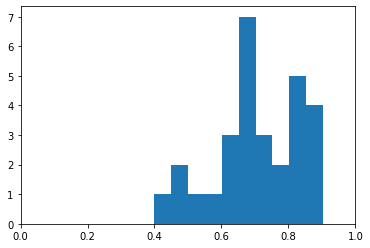

In [727]:
agg_scores1y = scores
print(np.median(agg_scores1y))
plt.hist(agg_scores1y);
plt.xlim(0, 1)